# Code for fig 1

In [1]:
## imports (generic)
import os
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular' # to use latex math symbols like mu

## Prepare inputs

In [2]:
## input data from peat_exp_analysis/v25, copied in folder ../data
path_data = '../data'
## set path for storing the figure made by this file
path_fig = '../fig'

In [3]:
## read in the data
## input data
TMP = xr.open_dataset(path_data + '/ds_for_eff.nc')
ds_for_eff = TMP.copy(deep=True)
## mask to filter out negative scenarios from input - to filter out scenarios that were not used in the experiment
TMP = xr.open_dataset(path_data + '/ds_subset_mask.nc')
ds_eff_mask = TMP.copy(deep=True)
## mask to filter out negative scenarios from output - to filter out scenarios with negative D_CO2 by 2300 (not used in analysis)
TMP = xr.open_dataset(path_data + '/ds_dco2_mask.nc')
ds_dco2_mask = TMP.copy(deep=True)
## non-overshoot related calculations
TMP = xr.open_dataset(path_data + '/ds_calc_nov.nc')
ds_calc_nov = TMP.copy(deep=True)
TMP = xr.open_dataset(path_data + '/ds_calc_nov_pt.nc')
ds_calc_nov_pt = TMP.copy(deep=True)
TMP = xr.open_dataset(path_data + '/ds_calc_nov_pt_obelix.nc')
ds_calc_nov_pt_obelix = TMP.copy(deep=True)

## Set plot related values such as colors

In [4]:
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88', '#ffbcaf', '#f4777f', '#cf3759', '#93003a'] 


In [5]:
# make a mask for selecting non-extreme values
mask_scen = ds_dco2_mask['mask_dco2'].drop(['year','var_name'])
mask_tg = ds_calc_nov_pt['best_guess'].sel(var_name='D_Tg') <= 200
mask_co2 = ds_calc_nov_pt['best_guess'].sel(var_name='D_CO2') <= 3000
mask_ept_co2 = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CO2') <= 0.07

# Combine the masks using logical OR to check if any criteria is met along the 'scen' dimension, including all four masks above
combined_mask = ~((~mask_tg).any(dim='year') & (~mask_co2).any(dim='year') & (~mask_ept_co2).any(dim='year')).drop('var_name')
combined_mask = combined_mask.where(mask_scen, drop=True)

define list of ssp scenarios (to remove from scens if needed) and corresponding colors

In [6]:
lst_ssp=['SSP1-1.9', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP4-3.4','SSP4-6.0', 'SSP5-3.4-OS']
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88', '#ffbcaf', '#f4777f', '#cf3759', '#93003a'] 
col_ssp_dsk = {'SSP1-1.9': '#00429d','SSP1-2.6': '#4771b2', 'SSP2-4.5':'#73a2c6', 'SSP3-7.0':'#ffcc88','SSP4-3.4': '#ffbcaf',
                 'SSP4-6.0':'#f4777f', 'SSP5-3.4-OS':'#cf3759','SSP5-8.5':'#83003a'}  

## Make subplots

Eff

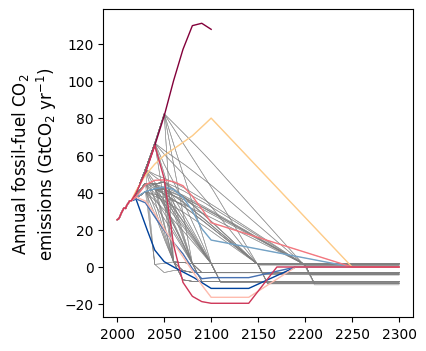

In [7]:
ds = ds_for_eff.where(combined_mask, drop=True).sel(year=slice(2000,2300))
ds85 = ds_for_eff.sel(year=slice(2000,2300),scen='SSP5-8.5')
plt.figure(figsize=(4., 4.))
plt.plot(ds.year,ds.Eff.sel(scen = ds.scen != 'SSP5-8.5').sum('reg_land')/12*44,color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds.year.sel(year=slice(2000,2100)),ds85.Eff.sel(year=slice(2000,2100)).sum('reg_land')/12*44,color = col_ssp_dsk['SSP5-8.5'], alpha = 1, lw=1)
for sn in lst_ssp:
    plt.plot(ds.year,ds.Eff.sel(scen = ds.scen == sn).sum('reg_land')/12*44,color = col_ssp_dsk[sn], alpha = 1, lw=1)    
plt.xlabel('', fontsize = 12)
plt.ylabel('Annual fossil-fuel CO$_2$ \nemissions (GtCO$_2$ yr$^{-1}$)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig1_Eff.png', dpi=300, bbox_inches='tight')

D_Tg

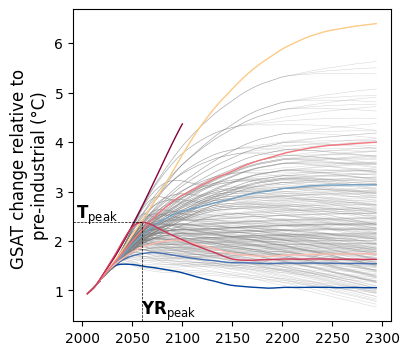

In [8]:
## filter out extreme values based on D_Tg, D_CO2 and D_CH4
ds = ds_calc_nov['best_guess'].sel(var_name='D_Tg').sel(year=slice(2000, 2299)).where(combined_mask, drop=True).rolling(year=11, center=True).mean()
ds85 = ds_calc_nov['best_guess'].sel(var_name='D_Tg').sel(year=slice(2000, 2299), scen='SSP5-8.5').rolling(year=11, center=True).mean()
ds34 = ds_calc_nov.sel(scen='SSP5-3.4-OS')
plt.figure(figsize=(4.1, 4.05))
plt.plot(ds.year,ds.sel(scen = ds.scen != 'SSP5-8.5'),color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds.year.sel(year=slice(2000,2100)),ds85.sel(year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'], alpha=1, lw=1)
for sn in lst_ssp:
    plt.plot(ds.year,ds.sel(scen = ds.scen == sn),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.ylabel('GSAT change relative to \npre-industrial (\u00B0C)', fontsize = 12)
## add two lines, to indicate the peak temperature for SSP5-3.4-OS, mark the temperature peak as Tpeak and the year as YRpeak, use ds34 to calculate
## make a simple horizental line, only for x <= the year at peak temperature
## get the max and min for the plot
xmin, xmax, ymin, ymax = plt.axis()
## calculate the scaled x position for the peak temperature
xpos = float(((ds34['Tpeak_yr_bg']-xmin)/(xmax-xmin)).values)
plt.axhline(y=ds34['Tpeak_bg'], color='k', linestyle='--', lw=0.5, xmin=0.0, xmax=xpos) 
## calculate the scaled y position for the peak temperature
ypos = float(((ds34['Tpeak_bg']-ymin)/(ymax-ymin)).values)
plt.axvline(x=ds34['Tpeak_yr_bg'], color='k', linestyle='--', lw=0.5, ymin=0.0, ymax=ypos)
#plt.axhline(y=ds34.sel(year=slice(2000,2100)).max().values, color='k', linestyle='--', lw=0.5)
## add text to indicate the peak temperature for SSP5-3.4-OS, right next to the line
plt.text(0.01, ds34['Tpeak_bg'] * 1.06, r'$T_{\mathrm{peak}}$', transform=plt.gca().get_yaxis_transform(), color='k', fontsize=12, fontweight='bold', va='center')
plt.text(ds34['Tpeak_yr_bg']*1.013, 0.035, r'$YR_{\mathrm{peak}}$', transform=plt.gca().get_xaxis_transform(), color='k', fontsize=12, fontweight='bold', ha='center', va='center')
plt.savefig(path_fig+'/sub_fig1_D_Tg.png', dpi=300, bbox_inches='tight')

D_CO2

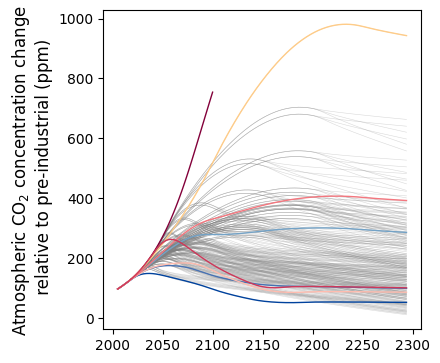

In [9]:
ds = ds_calc_nov['best_guess'].sel(var_name='D_CO2').sel(year=slice(2000, 2299)).where(combined_mask, drop=True).rolling(year=11, center=True).mean()
ds85 = ds_calc_nov['best_guess'].sel(var_name='D_CO2').sel(year=slice(2000, 2299), scen='SSP5-8.5').rolling(year=11, center=True).mean()
plt.figure(figsize=(4.1, 4.15))
plt.plot(ds.year,ds.sel(scen = ds.scen != 'SSP5-8.5'),color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds.year.sel(year=slice(2000,2100)),ds85.sel(year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'], alpha=1, lw=1)
for sn in lst_ssp:
    plt.plot(ds.year,ds.sel(scen = ds.scen == sn),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.ylabel('Atmospheric CO$_2$ concentration change \n relative to pre-industrial (ppm)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig1_D_CO2.png', dpi=300, bbox_inches='tight')

D_CH4

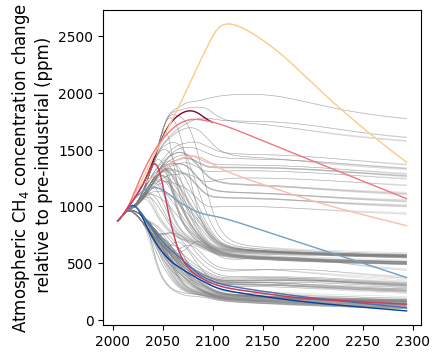

In [10]:
ds = ds_calc_nov['best_guess'].sel(var_name='D_CH4').sel(year=slice(2000, 2299)).where(combined_mask, drop=True).rolling(year=11, center=True).mean()
ds85 = ds_calc_nov['best_guess'].sel(var_name='D_CH4').sel(year=slice(2000, 2299), scen='SSP5-8.5').rolling(year=11, center=True).mean()
plt.figure(figsize=(4.1, 4.1))
plt.plot(ds.year,ds.sel(scen = ds.scen != 'SSP5-8.5'),color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds.year.sel(year=slice(2000,2100)),ds85.sel(year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'], alpha=1,lw=1)
for sn in lst_ssp:
    plt.plot(ds.year,ds.sel(scen = ds.scen == sn),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.ylabel('Atmospheric CH$_4$ concentration change \n relative to pre-industrial (ppm)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig1_D_CH4_pt.png', dpi=300, bbox_inches='tight')

NH peatland CO2 emissions

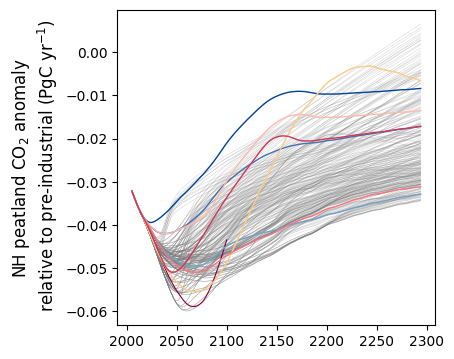

In [11]:
ds = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CO2').sel(year=slice(2000, 2299)).where(combined_mask, drop=True).rolling(year=11, center=True).mean()
ds85 = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CO2').sel(year=slice(2000, 2299), scen='SSP5-8.5').rolling(year=11, center=True).mean()
plt.figure(figsize=(4.1, 4.1))
plt.plot(ds.year,ds.sel(scen = ds.scen != 'SSP5-8.5'),color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds.year.sel(year=slice(2000,2100)),ds85.sel(year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'], lw=0.8)
for sn in lst_ssp:
    plt.plot(ds.year,ds.sel(scen = ds.scen == sn),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.ylabel('NH peatland CO$_2$ anomaly \n relative to pre-industrial (PgC yr$^{-1}$)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig1_D_Ept_CO2.png', dpi=300, bbox_inches='tight')

NH peatland CH4 emissions

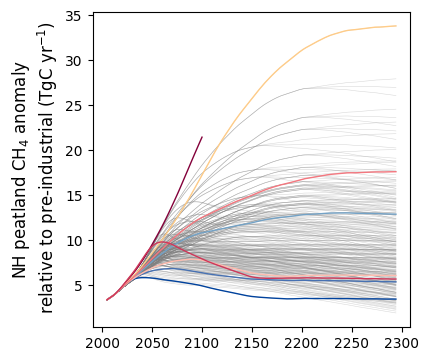

In [12]:
ds = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CH4').sel(year=slice(2000, 2299)).where(combined_mask, drop=True).rolling(year=11, center=True).mean()
ds85 = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CH4').sel(year=slice(2000, 2299), scen='SSP5-8.5').rolling(year=11, center=True).mean()
plt.figure(figsize=(4.1, 4.1))
plt.plot(ds.year,ds.sel(scen = ds.scen != 'SSP5-8.5'),color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds.year.sel(year=slice(2000,2100)),ds85.sel(year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'], alpha=1, lw=1)
for sn in lst_ssp:
    plt.plot(ds.year,ds.sel(scen = ds.scen == sn),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.ylabel('NH peatland CH$_4$ anomaly \n relative to pre-industrial (TgC yr$^{-1}$)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig1_D_Ept_CH4.png', dpi=300, bbox_inches='tight')

NH peatland impact on temperature

/var/folders/_6/nznq7gx573lgf75xyy6hlgr00000gn/T/ipykernel_38151/1974545170.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xpos = float(((YRmax-xmin)/(xmax-xmin)).values)


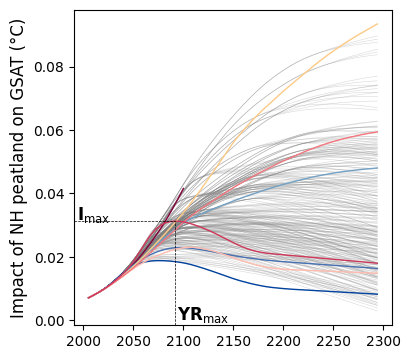

In [13]:
ds_pt = ds_calc_nov_pt['best_guess'].sel(var_name='D_Tg').sel(year=slice(2000, 2299)).where(combined_mask, drop=True).rolling(year=11, center=True).mean()
ds85_pt = ds_calc_nov_pt['best_guess'].sel(var_name='D_Tg').sel(year=slice(2000, 2299), scen='SSP5-8.5').rolling(year=11, center=True).mean()

ds = ds_calc_nov['best_guess'].sel(var_name='D_Tg').sel(year=slice(2000, 2299)).where(combined_mask, drop=True).rolling(year=11, center=True).mean()
ds85 = ds_calc_nov['best_guess'].sel(var_name='D_Tg').sel(year=slice(2000, 2299), scen='SSP5-8.5').rolling(year=11, center=True).mean()

deltaT = ds_pt-ds
deltaT585 = ds85_pt-ds85
deltaT34 = deltaT.sel(scen='SSP5-3.4-OS')

plt.figure(figsize=(4.1, 4.1))
plt.plot(deltaT.year,deltaT,color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds.year.sel(year=slice(2000,2100)),deltaT585.sel(year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'],alpha=1, lw=1)
for sn in lst_ssp:
    plt.plot(deltaT.year,deltaT.sel(scen = ds.scen == sn),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.ylabel('Impact of NH peatland on GSAT (\u00B0C)', fontsize = 12)
## add two lines, to indicate the peak change for SSP5-3.4-OS, mark the peak impact as Imax and the year as YRmax, use ds34 to calculate
## make a simple horizental line, only for x <= the year at peak temperature
## get the max and min for the plot
xmin, xmax, ymin, ymax = plt.axis()
## calculate the scaled x position for the peak temperature
Imax = deltaT34.max()
YRmax = deltaT34.where(deltaT34==deltaT34.max(),drop=True).year
xpos = float(((YRmax-xmin)/(xmax-xmin)).values)
plt.axhline(y=deltaT34.max(), color='k', linestyle='--', lw=0.5, xmin=0.0, xmax=xpos) 
## calculate the scaled y position for the peak temperature
ypos = float(((Imax-ymin)/(ymax-ymin)).values)
plt.axvline(x=YRmax, color='k', linestyle='--', lw=0.5, ymin=0.0, ymax=ypos)
## add text to indicate the peak temperature for SSP5-3.4-OS, right next to the line
plt.text(0.01, Imax*1.07, r'$I_{\max}$', transform=plt.gca().get_yaxis_transform(), color='k', fontsize=12, fontweight='bold', va='center')
plt.text(YRmax*1.013, 0.035, r'$YR_{\max}$', transform=plt.gca().get_xaxis_transform(), color='k', fontsize=12, fontweight='bold', ha='center', va='center')
plt.savefig(path_fig+'/sub_fig1_deltaT.png', dpi=300, bbox_inches='tight')

## Combine plots

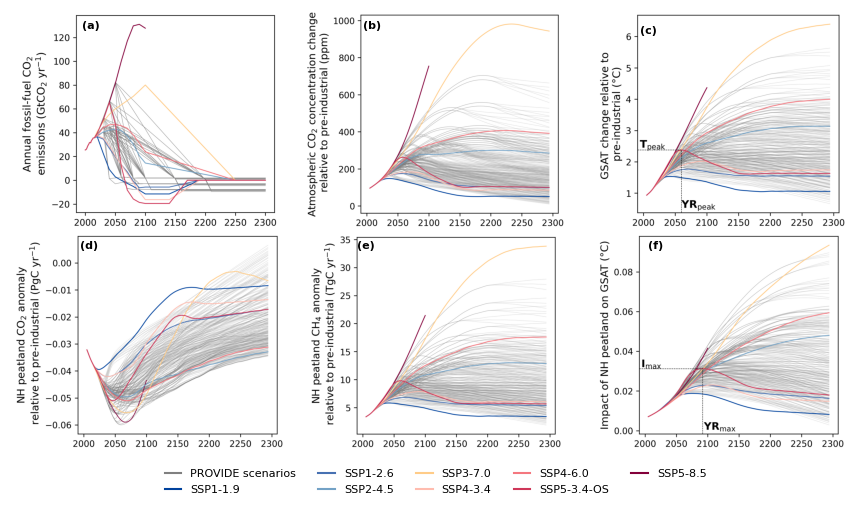

In [15]:
## combine six saved figures into one
fig, axs = plt.subplots(2, 3, figsize=(9, 5))
axs = axs.ravel()
## read in plot Eff
axs[0].imshow(plt.imread(path_fig+'/sub_fig1_Eff.png'))
## read in plot D_Tg
axs[1].imshow(plt.imread(path_fig+'/sub_fig1_D_CO2.png'))
## read in plot D_CO2
axs[2].imshow(plt.imread(path_fig+'/sub_fig1_D_Tg.png'))
## read in plot D_Ept_CO2
axs[3].imshow(plt.imread(path_fig+'/sub_fig1_D_Ept_CO2.png'))
## read in plot D_Ept_CH4
axs[4].imshow(plt.imread(path_fig+'/sub_fig1_D_Ept_CH4.png'))
## read in plot deltaT
axs[5].imshow(plt.imread(path_fig+'/sub_fig1_deltaT.png'))
## add labels to each subplot to the top left corner
axs[0].text(0.25, 0.95, '(a)', transform=axs[0].transAxes, fontsize=8, fontweight='bold', va='top')
axs[1].text(0.23, 0.95, '(b)', transform=axs[1].transAxes, fontsize=8, fontweight='bold', va='top')
axs[2].text(0.18, 0.93, '(c)', transform=axs[2].transAxes, fontsize=8, fontweight='bold', va='top')
axs[3].text(0.25, 0.95, '(d)', transform=axs[3].transAxes, fontsize=8, fontweight='bold', va='top')
axs[4].text(0.2, 0.95, '(e)', transform=axs[4].transAxes, fontsize=8, fontweight='bold', va='top')
axs[5].text(0.21, 0.95, '(f)', transform=axs[5].transAxes, fontsize=8, fontweight='bold', va='top')
## remove the box around each subplot
for ax in axs:
    ax.axis('off')
## generate legends for all subplots together. I want to add a legend for each color, but only once for each color.
## first define the colors and labels, colors are from col_ssp_dsk, all labels are solid lines with corresponding color
col_ssp_dsk = {'PROVIDE scenarios':'gray','SSP1-1.9': '#00429d','SSP1-2.6': '#4771b2', 'SSP2-4.5':'#73a2c6', 'SSP3-7.0':'#ffcc88','SSP4-3.4': '#ffbcaf',
                    'SSP4-6.0':'#f4777f', 'SSP5-3.4-OS':'#cf3759','SSP5-8.5':'#83003a'}
labels = ['PROVIDE scenarios','SSP1-1.9', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP4-3.4','SSP4-6.0', 'SSP5-3.4-OS', 'SSP5-8.5']
# Create a legend for the colors and labels with manual location
legend = axs[4].legend(handles=[plt.Line2D([0], [0], color=col_ssp_dsk[label], label=label) for label in labels],
                       bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=5, fontsize=8, frameon=False, handlelength=1.5)
# Adjust the spacing between subplots to make them tighter
plt.subplots_adjust(top=0.99, bottom=0.1, left=0.01, right=1., hspace=-0.02, wspace=-0.1)
# Ensure that the legend is within the figure
#plt.tight_layout()
## Save as PNG
plt.savefig(path_fig+'/figure1.png', dpi=300, bbox_inches='tight')
## Save as PDF
plt.savefig(path_fig + '/figure1.pdf', bbox_inches='tight')